# Long Term Trends

## Load long term trends data

In [57]:
import pandas as pd
import numpy as np
GBQ_PROJECT_ID = '620265099307'

q4 = '''-- opioid long term data extraction 
SELECT 
  year,
  l.chem_substance,
  l.Is_LA, 
  l.Is_High_LA,
  sum(itemsper1000) as items_per_1000, 
  sum(quantityper1000) as quantity_per_1000,
  sum(quantityper1000*dose_per_unit*new_ome_multiplier) AS total_ome_per_1000,
  sum(Infl_corr_Cost_per1000) as cost_per_1000
FROM ebmdatalab.helen.trends_from_pca_final_2016 p
INNER JOIN (SELECT distinct drug_name, chem_substance, Is_LA, Is_High_LA, dose_per_unit, new_ome_multiplier FROM ebmdatalab.richard.opioid_converter) l on l.drug_name = p.drug_name

GROUP BY 
  year,
  chem_substance,
  Is_LA, 
  Is_High_LA'''


dfl = pd.io.gbq.read_gbq(q4, GBQ_PROJECT_ID, dialect='standard',verbose=True).fillna(0)
dfl.head()

Requesting query... ok.
Job ID: 96d7fbfd-2365-4f02-8eea-995ad0f88b44
Query running...
Query done.
Processed: 9.6 MB Billed: 20.0 MB
Standard price: $0.00 USD

Retrieving results...
Got 735 rows.

Total time taken 3.5 s.
Finished at 2018-02-23 17:03:03.


,year,chem_substance,Is_LA,Is_High_LA,items_per_1000,quantity_per_1000,total_ome_per_1000,cost_per_1000
0,2016,Fentanyl,False,0,0.644549,32.999669,1827.039536,198.999152
1,2005,Fentanyl,False,0,0.159981,6.487472,331.346876,51.962514
2,2014,Fentanyl,False,0,0.671876,30.915705,1679.742785,191.646487
3,2012,Fentanyl,False,0,0.654114,26.049815,1289.582811,170.470378
4,2010,Fentanyl,False,0,0.608026,24.425398,1149.247813,156.217382


In [58]:
# tidy data
dfl.loc[dfl["Is_High_LA"]!="TRUE","Is_High_LA"] = "Others"
dfl.loc[dfl["Is_High_LA"]=="TRUE","Is_High_LA"] = "High dose"
dfl.groupby("Is_High_LA").sum()

,year,Is_LA,items_per_1000,quantity_per_1000,total_ome_per_1000,cost_per_1000
Is_High_LA,,,,,,
High dose,206851,103.0,238.835444,7.631766e+03,1.134939e+06,21054.861411
Others,1268542,122.0,12182.234138,1.253601e+06,4.545352e+06,97875.820915


## Summary results tables

In [61]:
# Summary results table by year
tab = dfl.fillna(0)
tab.loc[tab["Is_High_LA"]=="High dose","OME per 1000_High Dose"] = tab["total_ome_per_1000"]
tab.loc[tab["Is_High_LA"]=="High dose","Items per 1000_High Dose"] = tab["items_per_1000"]
tab.loc[tab["Is_High_LA"]=="High dose","Cost per 1000_High Dose"] = tab["cost_per_1000"]

tab.loc[tab["Is_LA"]==True,"OME per 1000_Long Acting"] = tab["total_ome_per_1000"]
tab.loc[tab["Is_LA"]==True,"Items per 1000_Long Acting"] = tab["items_per_1000"]
tab.loc[tab["Is_LA"]==True,"Cost per 1000_Long Acting"] = tab["cost_per_1000"]

tab = tab.fillna(0)
tab = tab.groupby(["year"]).sum().drop(["Is_LA","quantity_per_1000"],axis=1)
tab = tab.rename(columns={"total_ome_per_1000":"OME per 1000_Total","items_per_1000":"Items per 1000_Total","cost_per_1000":"Cost per 1000_Total"})


tab["OME per 1000_% High Dose"] = (100*tab["OME per 1000_High Dose"]/tab["OME per 1000_Long Acting"])
tab["Items per 1000_% High Dose"] = (100*tab["Items per 1000_High Dose"]/tab["Items per 1000_Long Acting"])
tab["Cost per 1000_% High Dose"] = (100*tab["Cost per 1000_High Dose"]/tab["Cost per 1000_Long Acting"])

tab.columns = tab.columns.str.split('_',expand=True)
tab.sort_index(axis=1, ascending=False)

OME per 1000                                          Items per 1000  \
              Total    Long Acting     High Dose % High Dose          Total   
year                                                                          
1998  190341.229235   33764.066808  17816.536462   52.767744     567.557547   
1999  195274.003496   37526.568896  19513.958995   52.000382     576.837185   
2000  198519.142275   41402.851678  21143.975521   51.068887     577.726742   
2001  208350.678733   47672.023794  24148.502620   50.655501     590.453673   
2002  219125.475986   55375.028140  28053.198938   50.660379     597.805263   
2003  231225.540390   64846.812741  33298.055102   51.348792     604.442720   
2004  243830.879617   74700.605742  38810.878660   51.955240     610.720277   
2005  238390.551008   87231.756381  46405.393945   53.197821     590.124946   
2006  253304.877486  101331.575530  54126.719644   53.415453     595.280682   
2007  277078.695792  115243.628877  61221.194252   53.123279     622.721137   
2008  296867.145716  127423.375439  66828.001096   52.445637     646.805865   
2009  322459.431096  143446.523094  73677.923113   51.362641     670.996889   
2010  349770.922727  160740.737450  81083.457397   50.443627     693.377043   
2011  372736.054212  173671.813554  86557.577353   49.839738     713.133850   
2012  392603.707247  184345.985621  91528.816627   49.650561     732.550936   
2013  408791.113419  193190.371857  95066.507840   49.208719     746.524956   
2014  421982.935208  202072.703553  97553.414978   48.276394     760.377085   
2015  428015.319102  207728.293610  98834.066436   47.578529     762.262847   
2016  431623.354911  211261.875811  99271.055455   46.989574     761.369940   

                                        Cost per 1000               \
     Long Acting  High Dose % High Dose         Total  Long Acting   
year                                                                 
1998   19.149703   3.322368   17.349449   3521.607789   821.086888   
1999   21.779254   3.699557   16.986609   4074.227752   943.402351   
2000   24.829942   4.048479   16.304828   4296.606905  1047.679173   
2001   28.700680   4.643628   16.179505   4341.730514  1224.565336   
2002   33.105700   5.419823   16.371268   4675.463166  1427.498874   
2003   37.830788   6.445684   17.038197   5042.454662  1669.045345   
2004   42.607272   7.456340   17.500158   5435.225409  1946.757870   
2005   48.271233   8.875035   18.385763   5943.315457  2193.434267   
2006   57.525566  10.697280   18.595696   7123.253607  2594.059322   
2007   67.823460  12.519467   18.458904   7707.328638  2975.948592   
2008   78.711940  14.212915   18.056873   7199.155209  3243.914980   
2009   89.913519  15.634277   17.388128   7391.995390  3549.043516   
2010   99.873619  16.906986   16.928380   7799.919648  3785.850867   
2011  108.599663  18.231728   16.788015   7212.922981  3664.702322   
2012  116.370133  19.617207   16.857596   7224.871444  3518.929138   
2013  123.172347  20.706144   16.810708   7412.957590  3566.258296   
2014  131.809705  21.588465   16.378509   7529.508873  3682.605633   
2015  138.438716  22.189672   16.028516   7858.289354  3740.265561   
2016  143.099347  22.620390   15.807473   7139.847935  3516.417734   

                               
        High Dose % High Dose  
year                           
1998   392.512604   47.804028  
1999   445.327497   47.204408  
2000   490.219417   46.790986  
2001   566.803772   46.286119  
2002   664.900015   46.577971  
2003   796.118116   47.699011  
2004   950.941890   48.847466  
2005  1105.662925   50.407844  
2006  1290.831797   49.761075  
2007  1444.653449   48.544301  
2008  1505.156997   46.399397  
2009  1574.061531   44.351711  
2010  1627.561403   42.990637  
2011  1498.217172   40.882370  
2012  1382.798620   39.296006  
2013  1388.154961   38.924689  
2014  1365.446030   37.078258  
2015  1339.231423   35.805784  
2016  1226.261790   34.872472

In [62]:
# Summary by chemical substance
tab = dfl.copy().fillna(0)
tab.loc[tab["Is_High_LA"]=="High dose","OME per 1000_High Dose"] = tab["total_ome_per_1000"]
tab.loc[tab["Is_High_LA"]=="High dose","Items per 1000_High Dose"] = tab["items_per_1000"]
tab.loc[tab["Is_High_LA"]=="High dose","Cost per 1000_High Dose"] = tab["cost_per_1000"]

tab.loc[tab["Is_LA"]==True,"OME per 1000_Long Acting"] = tab["total_ome_per_1000"]
tab.loc[tab["Is_LA"]==True,"Items per 1000_Long Acting"] = tab["items_per_1000"]
tab.loc[tab["Is_LA"]==True,"Cost per 1000_Long Acting"] = tab["cost_per_1000"]

tab = tab.fillna(0)
tab = tab.groupby(["chem_substance"]).sum().drop(["year","Is_LA","quantity_per_1000"],axis=1).sort_values(by="total_ome_per_1000",ascending=False)
tab = tab.rename(columns={"total_ome_per_1000":"OME per 1000_Total","items_per_1000":"Items per 1000_Total","cost_per_1000":"Cost per 1000_Total"})


tab["OME per 1000_% High Dose"] = (100*tab["OME per 1000_High Dose"]/tab["OME per 1000_Long Acting"])
tab["Items per 1000_% High Dose"] = (100*tab["Items per 1000_High Dose"]/tab["Items per 1000_Long Acting"])
tab["Cost per 1000_% High Dose"] = (100*tab["Cost per 1000_High Dose"]/tab["Cost per 1000_Long Acting"])

tab.columns = tab.columns.str.split('_',expand=True)
tab.sort_index(axis=1, ascending=False).fillna(0).head()

OME per 1000                 \
                                               Total    Long Acting   
chem_substance                                                        
Co-codamol                              1.030538e+06       0.000000   
Morphine Sulfate                        9.741007e+05  729644.895960   
Tramadol Hydrochloride                  9.367650e+05  266200.326446   
Fentanyl                                6.377592e+05  623525.128073   
Co-proxamol                             5.104952e+05       0.000000   
Oxycodone Hydrochloride                 4.611139e+05  346665.967704   
Buprenorphine                           3.196401e+05  262743.655872   
Dihydrocodeine Tartrate                 2.395312e+05       0.000000   
Codeine Phosphate                       2.078936e+05       0.000000   
Co-dydramol                             1.573908e+05       0.000000   
Methadone Hydrochloride                 6.979766e+04       0.000000   
Diamorphine Hydrochloride (Systemic)    5.375319e+04       0.000000   
Oxycodone HCl/Naloxone HCl              1.692247e+04   16922.190448   
Meptazinol Hydrochloride                1.655601e+04       0.000000   
Tapentadol Hydrochloride                1.283372e+04   10534.001922   
Hydromorphone Hydrochloride             8.404803e+03    6740.432150   
Pethidine Hydrochloride                 7.902676e+03       0.000000   
Dextromoramide Tartrate                 6.078493e+03       0.000000   
Pentazocine Hydrochloride               5.650996e+03       0.000000   
Dipipanone Hydrochloride                3.573377e+03       0.000000   
Aspirin & Papaveretum                   1.095892e+03       0.000000   
Ibuprofen & Codeine                     6.612683e+02       0.000000   
Morphine Tartrate & Cyclizine Tartrate  5.357550e+02       0.000000   
Phenazocine Hydrobromide                3.380860e+02       0.000000   
Dextropropoxyphene                      3.324836e+02       0.000000   
Co-codaprin                             2.292260e+02       0.000000   
Oxycodone                               2.185343e+02       0.000000   
Pentazocine Lactate                     9.890506e+01       0.000000   
Nalbuphine Hydrochloride                3.334333e+01       0.000000   
Papaveretum                             3.069785e+01       0.000000   
Morphine Hydrochloride                  1.591487e+01       0.000000   
Powdered Opium                          0.000000e+00       0.000000   

                                                                   \
                                            High Dose % High Dose   
chem_substance                                                      
Co-codamol                                   0.000000    0.000000   
Morphine Sulfate                        362016.303968   49.615410   
Tramadol Hydrochloride                       0.000000    0.000000   
Fentanyl                                475372.991112   76.239588   
Co-proxamol                                  0.000000    0.000000   
Oxycodone Hydrochloride                 209160.146752   60.334779   
Buprenorphine                            74738.806295   28.445523   
Dihydrocodeine Tartrate                      0.000000    0.000000   
Codeine Phosphate                            0.000000    0.000000   
Co-dydramol                                  0.000000    0.000000   
Methadone Hydrochloride                      0.000000    0.000000   
Diamorphine Hydrochloride (Systemic)         0.000000    0.000000   
Oxycodone HCl/Naloxone HCl                4785.127183   28.277233   
Meptazinol Hydrochloride                     0.000000    0.000000   
Tapentadol Hydrochloride                  4873.248244   46.262079   
Hydromorphone Hydrochloride               3992.610881   59.233752   
Pethidine Hydrochloride                      0.000000    0.000000   
Dextromoramide Tartrate                      0.000000    0.000000   
Pentazocine Hydrochloride                    0.000000    0.000000   
Dipipanone Hydrochloride            

In [63]:
# Summary by chemical substance and year (OME only)
tab = dfl.fillna(0)
tab.loc[tab["Is_High_LA"]=="High dose","OME per 1000_High Dose"] = tab["total_ome_per_1000"]

tab.loc[tab["Is_LA"]==True,"OME per 1000_Long Acting"] = tab["total_ome_per_1000"]

grp = tab.loc[tab["year"]==2016]
grp = grp[["chem_substance","OME per 1000_Long Acting"]].groupby(["chem_substance"]).sum().fillna(0).sort_values(by="OME per 1000_Long Acting",ascending=False).reset_index()
grp["chemical"] = np.where(grp.index>5,"Other",grp.chem_substance)
grp = grp.drop(["OME per 1000_Long Acting"], axis=1)
tab2 = tab.reset_index().merge(grp,on="chem_substance")
tab2 = tab2[["year","chemical","total_ome_per_1000","OME per 1000_Long Acting","OME per 1000_High Dose"]].fillna(0)

tab2 = tab2.groupby(["year","chemical"]).sum().sort_values(by="total_ome_per_1000",ascending=False)
tab2 = tab2.rename(columns={"total_ome_per_1000":"OME per 1000_Total"})

tab2 = pd.DataFrame(tab2.stack()).reset_index().rename(columns={"level_2": 'measure', 0:"value"})
tab2 = tab2.set_index(["measure","year","chemical"]).unstack().fillna(0)
tab2["Total"] = tab2.sum(axis=1)
tab2

value                                 \
chemical                      Buprenorphine      Fentanyl Morphine Sulfate   
measure                  year                                                
OME per 1000_High Dose   1998      0.000000   5655.809228     11964.498593   
                         1999      0.000000   7022.631743     12179.536597   
                         2000      0.000000   8223.404891     12249.610934   
                         2001      0.000000   9594.946380     13047.660754   
                         2002    336.468026  11615.772364     13500.653793   
                         2003   1484.425394  14019.099658     14116.829476   
                         2004   2661.781148  16378.376957     14607.240819   
                         2005   3838.949057  20140.796348     15555.950875   
                         2006   4882.015022  24188.023593     16539.507743   
                         2007   5056.364772  27919.525273     17778.555150   
                         2008   5213.920669  31346.148962     19222.714070   
                         2009   5563.024576  34063.828540     20672.987984   
                         2010   5902.401596  36182.278957     22366.669326   
                         2011   6180.230025  37382.924349     24168.382442   
                         2012   6314.783386  38010.523856     25904.127215   
                         2013   6513.013600  38428.632268     26850.479711   
                         2014   6783.950395  38764.402411     27230.733514   
                         2015   6971.161477  38442.691695     27339.339397   
                         2016   7036.317152  37993.173639     26720.825576   
OME per 1000_Long Acting 1998      0.000000   6839.326022     22013.402129   
                         1999      0.000000   8515.629302     22545.790683   
                         2000      0.000000   9974.976693     22796.302401   
                         2001      0.000000  11727.113006     24044.909878   
                         2002    794.869654  14282.349792     24674.677381   
                         2003   2853.191896  17311.821013     25687.694865   
                         2004   4753.137589  20239.860463     26796.078861   
                         2005   6734.467533  24822.596419     28479.237541   
                         2006   9517.786490  29954.735608     30577.104770   
                         2007  11712.349249  35212.450088     33477.218471   
                         2008  14573.956797  40131.269483     36222.576661   
                         2009  17966.164563  44148.262639     39787.594068   
                         2010  21047.506254  47422.133888     43955.209194   
                         2011  23714.243040  49586.680315     48869.798163   
                         2012  25648.082073  51130.837613     53979.206710   
                         2013  27474.586101  52313.514371     57949.825121   
                         2014  30087.077026  53372.159097     61083.703509   
                         2015  32156.286079  53362.776482     62842.184451   
                         2016  33709.951527  53176.635781     63862.381102   
OME per 1000_Total       1998   3195.175807   6839.326022     26259.609673   
                         1999   3019.658229   8515.629302     27271.544208   
                         2000   2781.970739   9974.976693     27975.997201   
                         2001   2624.194970  11744.707855     29886.800628   
                         2002   3359.590332  14374.045528     31067.124154   
                         2003   5400.250694  17407.748345     32662.352946   
                         2004   7204.328952  20454.872436     34442.990720   
                         2005   9149.415484  25153.943295     37220.185927   
                         2006  11904.899932  30430.555579     40348.789723   
                         2007  14220.134057  35795.702684     44780.127051   
                         2008  17119.204067  40899.562227   

## Plot data - all opioids

findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=17.0 to Arial ('C:\\Windows\\Fonts\\arial.ttf') with score of 0.050000


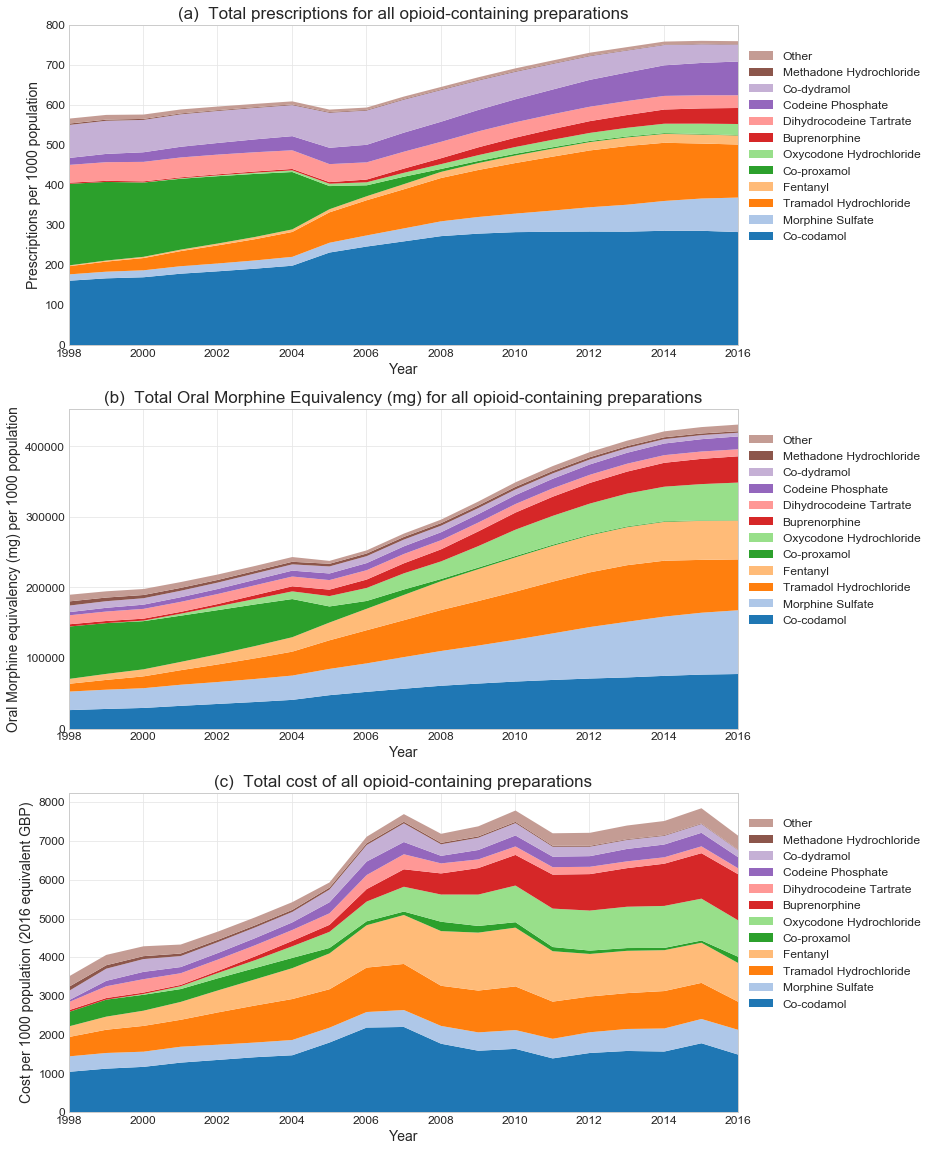

In [70]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid",{'grid.color': '.9'})
sns.set_palette("tab20",n_colors=14)

dft = dfl.groupby("chem_substance")["total_ome_per_1000"].sum().sort_values(ascending=False).reset_index().rename(columns={"total_ome_per_1000":"total_ome_all_years"})
sort_order = pd.Series(dft.chem_substance.drop_duplicates())

grp = pd.DataFrame(sort_order).reset_index()
grp["chemical"] = np.where(grp.index>10,"Other",grp.chem_substance)
grp["other_flag"] = np.where(grp.index>10,0,1)
dfl2 = dfl.merge(grp,on="chem_substance")

dfs = dfl2.groupby(["other_flag","chemical"])["total_ome_per_1000"].sum().sort_values(ascending=False).reset_index().rename(columns={"total_ome_per_1000":"total_ome_all_years"}).sort_values(by=["other_flag","total_ome_all_years"],ascending=False)
sort_order = pd.Series(dfs.chemical)


s=[(0,'(a)  Total prescriptions for all opioid-containing preparations','Prescriptions per 1000 population','items_per_1000'),
   (1,'(b)  Total Oral Morphine Equivalency (mg) for all opioid-containing preparations','Oral Morphine equivalency (mg) per 1000 population',"total_ome_per_1000"),
   (2,'(c)  Total cost of all opioid-containing preparations','Cost per 1000 population (2016 equivalent GBP)','cost_per_1000')]

fig = plt.figure(figsize=(15,20))
   
for i in s:
    ax = plt.subplot(3,1,i[0]+1)  # layout and position of subplot
    if i[0]==0:
        dfp = dfl2.groupby(['year','chemical'])[i[3]].sum().unstack()
        dfp = dfp.reindex(columns=sort_order)
    if i[0]==1:
        dfp = dfl2.groupby(['year','chemical'])[i[3]].sum().unstack()
        dfp = dfp.reindex(columns=sort_order)
    if i[0]==2:
        dfp = dfl2.groupby(['year','chemical'])[i[3]].sum().unstack()
        dfp = dfp.reindex(columns=sort_order)
    dfp.plot(ax=ax, kind='area',  linewidth=0)
    ax.set_xlabel('Year', size="14")
    ax.set_ylabel(i[2], size="14")
    ax.tick_params(labelsize=12)
    ax.set_title(i[1], size="17")
    handles, labels = ax.get_legend_handles_labels()
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(reversed(handles), reversed(labels),loc='center left', fontsize="12",bbox_to_anchor=(1, .62))

plt.show()



## Plot data - long acting preparations

In [2]:
la_df = dfl.loc[(dfl['Is_LA'] == True)]

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid",{'grid.color': '.9'})
sns.set_palette("Set3",n_colors=14)

dft = la_df.groupby("chem_substance")["total_ome_per_1000"].sum().sort_values(ascending=False).reset_index().rename(columns={"total_ome_per_1000":"total_ome_all_years"})
sort_order = pd.Series(dft.chem_substance.drop_duplicates())

grp = pd.DataFrame(sort_order).reset_index()
grp["chemical"] = np.where(grp.index>11,"Other",grp.chem_substance)
dfl2 = la_df.merge(grp,on="chem_substance")

dfs = dfl2.groupby("chemical")["total_ome_per_1000"].sum().sort_values(ascending=False).reset_index().rename(columns={"total_ome_per_1000":"total_ome_all_years"})
sort_order = pd.Series(dfs.chemical)


s=[(0,'(a)  Total prescriptions for long-acting opioid preparations','Prescriptions per 1000 population','items_per_1000'),
   (1,'(b)  Total Oral Morphine Equivalency (mg) for long-acting opioid preparations','Oral Morphine equivalency (mg) per 1000 population',"total_ome_per_1000"),
   (2,'(c)  Total cost of long-acting opioid preparations','Cost per 1000 population (GBP)','cost_per_1000')]

fig = plt.figure(figsize=(15,20))
   
for i in s:
    ax = plt.subplot(3,1,i[0]+1)  # layout and position of subplot
    if i[0]==0:
        dfp = dfl2.groupby(['year','chemical'])[i[3]].sum().unstack()
        dfp = dfp.reindex(columns=sort_order)
    if i[0]==1:
        dfp = dfl2.groupby(['year','chemical'])[i[3]].sum().unstack()
        dfp = dfp.reindex(columns=sort_order)
    if i[0]==2:
        dfp = dfl2.groupby(['year','chemical'])[i[3]].sum().unstack()
        dfp = dfp.reindex(columns=sort_order)
    dfp.plot(ax=ax, kind='area',  linewidth=0)
    ax.set_xlabel('Year', size="14")
    ax.set_ylabel(i[2], size="14")
    ax.tick_params(labelsize=12)
    ax.set_title(i[1], size="17")
    handles, labels = ax.get_legend_handles_labels()
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(reversed(handles), reversed(labels),loc='center left', fontsize="12",bbox_to_anchor=(1, .62))

plt.show()



NameError: name 'dfl' is not defined

## Plot data - High dose opioids

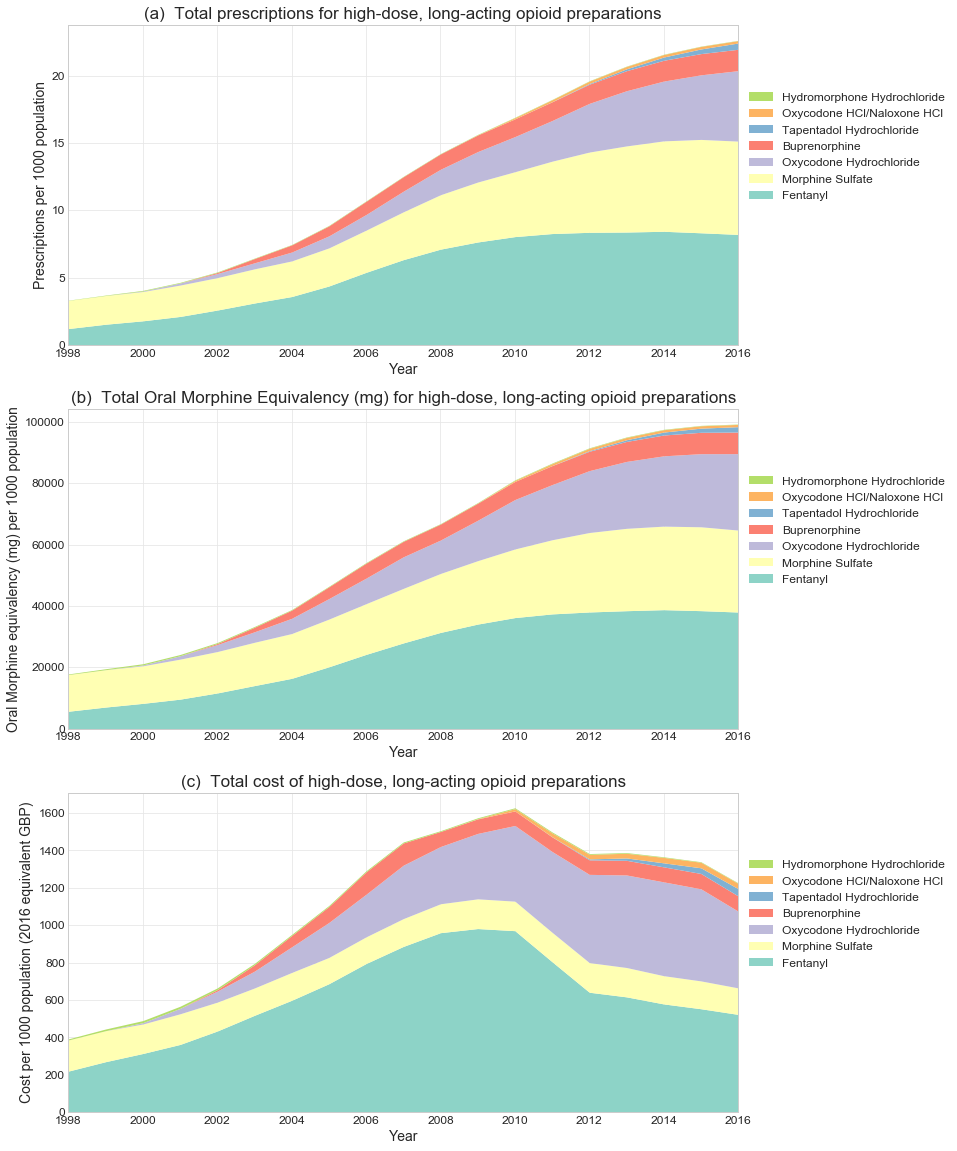

In [72]:
high_df = dfl.loc[(dfl['Is_High_LA'] == "High dose")]

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid",{'grid.color': '.9'})
sns.set_palette("Set3",n_colors=14)

dft = high_df.groupby("chem_substance")["total_ome_per_1000"].sum().sort_values(ascending=False).reset_index().rename(columns={"total_ome_per_1000":"total_ome_all_years"})
sort_order = pd.Series(dft.chem_substance.drop_duplicates())

grp = pd.DataFrame(sort_order).reset_index()
grp["chemical"] = np.where(grp.index>11,"Other",grp.chem_substance)
dfl2 = high_df.merge(grp,on="chem_substance")

dfs = dfl2.groupby("chemical")["total_ome_per_1000"].sum().sort_values(ascending=False).reset_index().rename(columns={"total_ome_per_1000":"total_ome_all_years"})

s=[(0,'(a)  Total prescriptions for high-dose, long-acting opioid preparations','Prescriptions per 1000 population','items_per_1000'),
   (1,'(b)  Total Oral Morphine Equivalency (mg) for high-dose, long-acting opioid preparations','Oral Morphine equivalency (mg) per 1000 population',"total_ome_per_1000"),
   (2,'(c)  Total cost of high-dose, long-acting opioid preparations','Cost per 1000 population (2016 equivalent GBP)', 'cost_per_1000')]

fig = plt.figure(figsize=(15,20))
   
for i in s:
    ax = plt.subplot(3,1,i[0]+1)  # layout and position of subplot
    if i[0]==1:
        dfp = dfl2.groupby(['year','chemical'])[i[3]].sum().unstack()
        dfp = dfp.reindex(columns=sort_order)
    if i[0]==0:
        dfp = dfl2.groupby(['year','chemical'])[i[3]].sum().unstack()
        dfp = dfp.reindex(columns=sort_order)
    if i[0]==2:
        dfp = dfl2.groupby(['year','chemical'])[i[3]].sum().unstack()
        dfp = dfp.reindex(columns=sort_order)
    dfp.plot(ax=ax, kind='area',  linewidth=0)
    ax.set_xlabel('Year', size="14")
    ax.set_ylabel(i[2], size="14")
    ax.tick_params(labelsize=12)
    ax.set_title(i[1], size="17")
    handles, labels = ax.get_legend_handles_labels()
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(reversed(handles), reversed(labels),loc='center left', fontsize="12",bbox_to_anchor=(1, .62))

plt.show()


## Plot data - less popular opioids (expand "Other" group)

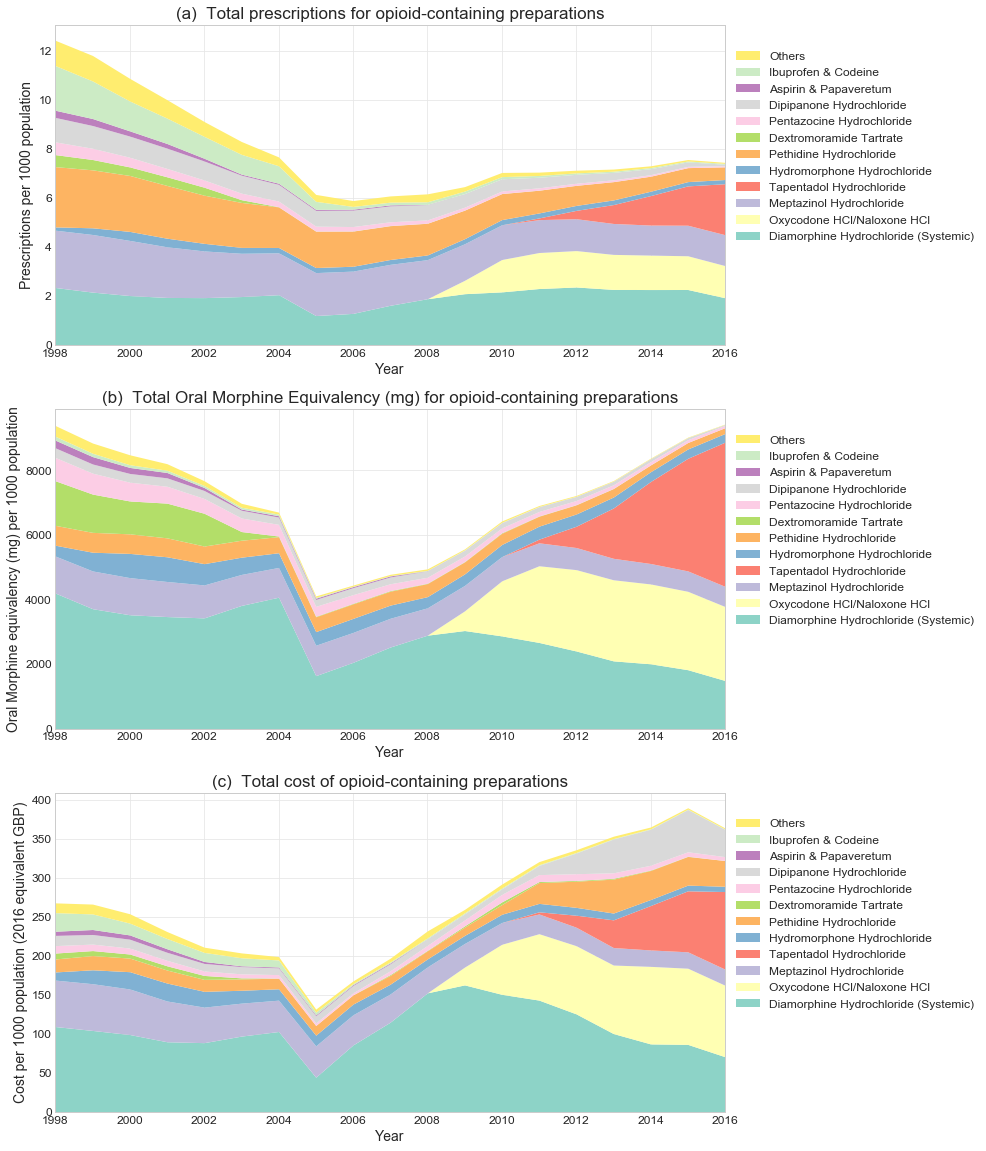

In [102]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid",{'grid.color': '.9'})
sns.set_palette("Set3",n_colors=14)

dft = dfl.groupby("chem_substance")["total_ome_per_1000"].sum().sort_values(ascending=False).reset_index().rename(columns={"total_ome_per_1000":"total_ome_all_years"})
sort_order = pd.Series(dft.chem_substance.drop_duplicates())

grp = pd.DataFrame(sort_order).reset_index()
grp = grp.loc[grp.index>=11].reset_index()
grp["chemical"] = np.where(grp.index>10,"Others",grp.chem_substance)
grp["other_flag"] = np.where(grp.index>10,0,1)
dfl2 = dfl.merge(grp,on="chem_substance")

dfs = dfl2.groupby(["other_flag","chemical"])["total_ome_per_1000"].sum().sort_values(ascending=False).reset_index().rename(columns={"total_ome_per_1000":"total_ome_all_years"}).sort_values(by=["other_flag","total_ome_all_years"],ascending=False)
sort_order = pd.Series(dfs.chemical)


s=[(0,'(a)  Total prescriptions for opioid-containing preparations','Prescriptions per 1000 population','items_per_1000'),
   (1,'(b)  Total Oral Morphine Equivalency (mg) for opioid-containing preparations','Oral Morphine equivalency (mg) per 1000 population',"total_ome_per_1000"),
   (2,'(c)  Total cost of opioid-containing preparations','Cost per 1000 population (2016 equivalent GBP)','cost_per_1000')]

fig = plt.figure(figsize=(15,20))
   
for i in s:
    ax = plt.subplot(3,1,i[0]+1)  # layout and position of subplot
    if i[0]==0:
        dfp = dfl2.groupby(['year','chemical'])[i[3]].sum().unstack()
        dfp = dfp.reindex(columns=sort_order)
    if i[0]==1:
        dfp = dfl2.groupby(['year','chemical'])[i[3]].sum().unstack()
        dfp = dfp.reindex(columns=sort_order)
    if i[0]==2:
        dfp = dfl2.groupby(['year','chemical'])[i[3]].sum().unstack()
        dfp = dfp.reindex(columns=sort_order)
    dfp.plot(ax=ax, kind='area',  linewidth=0)
    ax.set_xlabel('Year', size="14")
    ax.set_ylabel(i[2], size="14")
    ax.tick_params(labelsize=12)
    ax.set_title(i[1], size="17")
    handles, labels = ax.get_legend_handles_labels()
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(reversed(handles), reversed(labels),loc='center left', fontsize="12",bbox_to_anchor=(1, .62))
    

plt.show()


In [3]:

import pandas as pd
import numpy as np
GBQ_PROJECT_ID = '620265099307'

q3 = '''
-- opioids - including practices open/prescribing but not prescribing opioids

-- create a table of all prescribing by practice by month.
WITH  A AS (
  SELECT practice, pct,
    CAST(month AS DATE) AS year_mon,
    sum(items) AS items
  FROM ebmdatalab.hscic.normalised_prescribing_standard p
  GROUP BY  practice, pct, year_mon),

-- inner join to practice list to filter for type 4 practices, and for months they had more than zero patients and more than zero total prescribing. 
q2 AS (
  SELECT a.practice, 
    a.pct,
    prac.status_code,
    a.year_mon, 
    MAX(a.items) AS items, 
    MAX(total_list_size) AS total_list_size
  FROM ebmdatalab.hscic.practice_statistics_all_years s
  LEFT JOIN A ON  a.practice = s.practice AND a.year_mon = CAST(s.month AS DATE)  
  INNER JOIN  ebmdatalab.hscic.practices prac ON prac.code=a.practice AND prac.setting = 4 
  WHERE total_list_size > 0 and items > 0
  GROUP BY practice, pct, status_code, year_mon )

  
SELECT 
  COALESCE(p.pct,q2.pct) AS pct,
  q2.practice,
  q2.status_code,
  q2.year_mon AS month,
  l.chem_substance,
  Is_LA,
  Is_High_LA,
  sum(p.items) as items, 
  sum(quantity) as quantity,
  sum(quantity*dose_per_unit*new_ome_multiplier) AS total_ome,
  sum(net_cost) as net_cost,
  sum(actual_cost) as actual_cost
FROM q2 
LEFT JOIN ebmdatalab.helen.opioid_prescribing_2010_2017 p ON p.practice = q2.practice AND CAST(p.month AS DATE) = q2.year_mon  
LEFT JOIN (SELECT distinct bnf_code, chem_substance, Is_High_LA, Is_LA, dose_per_unit, new_ome_multiplier FROM ebmdatalab.richard.opioid_converter) l on l.bnf_code = p.bnf_code

GROUP BY 
  pct,
  practice,
  status_code,
  month,
  chem_substance,
  Is_LA,
  Is_High_LA
'''

df1 = pd.io.gbq.read_gbq(q3, GBQ_PROJECT_ID, dialect='standard',verbose=True)




Requesting query... ok.
Job ID: 0f0e4ec8-f731-41d6-9592-4e9e75f083ee
Query running...
  Elapsed 7.28 s. Waiting...
  Elapsed 8.56 s. Waiting...
  Elapsed 9.82 s. Waiting...
  Elapsed 11.1 s. Waiting...
  Elapsed 12.38 s. Waiting...
  Elapsed 13.65 s. Waiting...
  Elapsed 14.9 s. Waiting...
  Elapsed 16.17 s. Waiting...
  Elapsed 17.44 s. Waiting...
  Elapsed 18.72 s. Waiting...
  Elapsed 19.98 s. Waiting...
  Elapsed 21.26 s. Waiting...
  Elapsed 22.52 s. Waiting...
  Elapsed 23.79 s. Waiting...
  Elapsed 25.02 s. Waiting...
  Elapsed 26.3 s. Waiting...
  Elapsed 27.57 s. Waiting...
  Elapsed 28.86 s. Waiting...
  Elapsed 30.13 s. Waiting...
  Elapsed 31.4 s. Waiting...
  Elapsed 32.66 s. Waiting...
  Elapsed 33.93 s. Waiting...
  Elapsed 35.23 s. Waiting...
  Elapsed 36.5 s. Waiting...
  Elapsed 37.78 s. Waiting...
  Elapsed 39.14 s. Waiting...
  Elapsed 40.44 s. Waiting...
  Elapsed 41.69 s. Waiting...
  Elapsed 42.93 s. Waiting...
  Elapsed 44.19 s. Waiting...
  Elapsed 45.44 s. Wai

In [1]:
import pandas as pd
import numpy as np
GBQ_PROJECT_ID = '620265099307'

q2 = '''SELECT practice, 
    pct_id AS CCG,
    month,
    total_list_size
from ebmdatalab.hscic.practice_statistics_all_years 
'''

pop = pd.io.gbq.read_gbq(q2, GBQ_PROJECT_ID, dialect='standard',verbose=False)

### Organise and filter practice-level data

In [2]:
import pandas as pd
import numpy as np

#load df1 as CSV for speed
df1 = pd.read_csv('opioids_all_practices.csv')


# convert dates to datetime format
df1["month"] = pd.to_datetime(df1.month)
df1 = df1.loc[df1["month"] <='2017-10-01'].reset_index() # remove any november data

# tidy data and replace nulls with appropriate blanks
df1.loc[df1["Is_High_LA"]!="TRUE","High_LA"] = False
df1.loc[df1["Is_High_LA"]=="TRUE","High_LA"] = True

for y in df1.columns:
    if(df1[y].dtype == np.float64):
          df1[y].fillna(0,inplace=True)
    else:
          df1[y].fillna('none',inplace=True)

# count included practices and CCGs
print (df1.practice.nunique()," total practices")


# Filter to latest 3 months only and currently active practices with standard CCG codes (for regression and mapping)

dftest = df1.loc[(df1["month"]>df1["month"].max()-pd.DateOffset(months=3))]
print ("Latest ", dftest.month.nunique()," months only:") 
print (dftest.practice.nunique()," practices including those not active / without valid CCG")

dftestc = dftest.loc[dftest["status_code"] == "C"]
print (dftestc.practice.nunique()," practices closed")
dftestd = dftest.loc[dftest["status_code"] == "D"]
print (dftestd.practice.nunique()," practices dormant")

dftest = dftest.loc[(dftest["pct"].str.match(r"([0-9]{2})([A-Za-z])")) & (dftest["status_code"] == "A")]
print (dftest.practice.nunique()," practices included")
print (dftest.pct.nunique()," CCGs")

C:\Users\hcurtis\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2698: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


8120  total practices
Latest  3  months only:
7346  practices including those not active / without valid CCG
0  practices closed
111  practices dormant
7234  practices included
207  CCGs


## Practice data for regression analysis

In [3]:
# use data filtered to latest 3 months only, and currently active practices with standard CCG codes. 
tab = dftest.copy()
tab = tab.drop(["status_code","Is_High_LA","total_ome","quantity","net_cost","actual_cost"],axis=1)

# create columns for high-dose and long-acting OME
tab.loc[tab["High_LA"]==True,"Items High Dose"] = tab["items"]
tab.loc[tab["Is_LA"]==True,"Items Long Acting"] = tab["items"]

# sum to aggregate months and chemical substances together
tab = tab.fillna(0).drop(["Is_LA","High_LA"],axis=1)
tab = tab.groupby(["pct","practice"]).sum().reset_index()

tab["Items % High Dose"] = (100*tab["Items High Dose"]/tab["Items Long Acting"])
tab.head()


,pct,practice,index,items,Items High Dose,Items Long Acting,Items % High Dose
0,00C,A83005,342707124,2780.0,124.0,638.0,19.435737
1,00C,A83006,281097632,1662.0,93.0,431.0,21.577726
2,00C,A83010,354361013,3489.0,123.0,928.0,13.254310
3,00C,A83013,286802943,3660.0,158.0,688.0,22.965116
4,00C,A83031,282455936,2021.0,79.0,471.0,16.772824


## Practice trends analysis (monthly data, 2010-2017)

### (a) Create calculated fields e.g total OME per 1000 population

In [4]:

df = df1.copy()

# tidy data
df = df.drop(["pct","Is_High_LA","quantity","net_cost"],axis=1)

# create columns for high dose and long acting OME
df.loc[df["Is_LA"]==True,"Items Long Acting"] = df["items"]
df.loc[df["High_LA"]==True,"Items High Dose"] = df["items"]
df.loc[df["Is_LA"]==True,"OME Long Acting"] = df["total_ome"]
df.loc[df["High_LA"]==True,"OME High Dose"] = df["total_ome"]
df.loc[df["Is_LA"]==True,"Cost Long Acting"] = df["actual_cost"]
df.loc[df["High_LA"]==True,"Cost High Dose"] = df["actual_cost"]

df = df.fillna(0).drop(["Is_LA","High_LA"],axis=1)
df = df.groupby(["month","practice"]).sum().drop("index",axis=1).reset_index()

df2 = df.rename(columns={"total_ome":"Total OME",
                          "items":"Total Items",
                          "actual_cost":"Total Cost"})

df2 = df2.merge(pop[["practice","month","total_list_size"]], on=["practice","month"])
df2["Percent high dose (by OME)"] = 100*df2["OME High Dose"]/df2["OME Long Acting"]
df2["Percent high dose (by items)"] = 100*df2["Items High Dose"]/df2["Items Long Acting"]
df2["Total OME (per 1000)"] = 1000*df2["Total OME"]/df2.total_list_size
df2["Total items (per 1000)"] = 1000*df2["Total Items"]/df2.total_list_size
df2["Total cost (per 1000)"] = 1000*df2["Total Cost"]/df2.total_list_size
df2["Cost high dose opioids (per 1000)"] = 1000*df2["Cost High Dose"]/df2.total_list_size

df2["High dose items (per 1000)"] = 1000*df2["Items High Dose"]/df2.total_list_size
df2["Long acting items (per 1000)"] = 1000*df2["Items Long Acting"]/df2.total_list_size
df2["High dose OME (per 1000)"] = 1000*df2["OME High Dose"]/df2.total_list_size
df2["Long acting OME (per 1000)"] = 1000*df2["OME Long Acting"]/df2.total_list_size
df2.head()

,month,practice,Total Items,Total OME,Total Cost,Items Long Acting,Items High Dose,OME Long Acting,OME High Dose,Cost Long Acting,...,Percent high dose (by OME),Percent high dose (by items),Total OME (per 1000),Total items (per 1000),Total cost (per 1000),Cost high dose opioids (per 1000),High dose items (per 1000),Long acting items (per 1000),High dose OME (per 1000),Long acting OME (per 1000)
0,2010-10-01,A81001,299.0,178334.6,2808.58,51.0,12.0,93352.0,56800.0,1742.93,...,60.844974,23.529412,42050.129686,70.502240,662.244754,214.767743,2.829521,12.025466,13393.067673,22011.789672
1,2010-10-01,A81002,1397.0,747647.2,11549.97,168.0,41.0,343928.0,185048.0,5383.39,...,53.804285,24.404762,36408.434380,68.030192,562.452885,128.972486,1.996591,8.181154,9011.346482,16748.380813
2,2010-10-01,A81003,419.0,211888.8,3048.76,47.0,15.0,84440.0,48240.0,1443.72,...,57.129323,31.914894,57174.527793,113.059903,822.655154,249.740961,4.047491,12.682137,13016.729628,22784.673502
3,2010-10-01,A81004,778.0,491505.3,8684.69,98.0,12.0,196640.0,85856.0,4199.26,...,43.661513,12.244898,60709.646739,96.096838,1072.713686,203.853755,1.482213,12.104743,10604.743083,24288.537549
4,2010-10-01,A81005,454.0,306033.6,4959.95,109.0,13.0,182819.6,72520.0,3292.71,...,39.667519,11.926606,38398.193225,56.963614,622.327478,146.146801,1.631117,13.676286,9099.121706,22938.469260


### (b) Calculate deciles

In [5]:
df3 = df2
x = np.arange(0.1, 1, 0.1) # set range of deciles required (0.1-0.9)
pc = df3.groupby('month').quantile(x)  # calculate deciles for each month
pc = pd.DataFrame(pc.stack()).reset_index().rename(columns={"level_1": 'percentile',"level_2": 'measure', 0:"value"}) # rearrange
pc["index"] = (pc.percentile*10).map(int) # create integer range of percentiles as integers are better for charts
pc.head(10)

,month,percentile,measure,value,index
0,2010-10-01,0.1,Cost High Dose,0.000000,1
1,2010-10-01,0.1,Cost Long Acting,212.606000,1
2,2010-10-01,0.1,Cost high dose opioids (per 1000),0.000000,1
3,2010-10-01,0.1,High dose OME (per 1000),0.000000,1
4,2010-10-01,0.1,High dose items (per 1000),0.000000,1
5,2010-10-01,0.1,Items High Dose,0.000000,1
6,2010-10-01,0.1,Items Long Acting,9.000000,1
7,2010-10-01,0.1,Long acting OME (per 1000),2824.554645,1
8,2010-10-01,0.1,Long acting items (per 1000),2.347768,1
9,2010-10-01,0.1,OME High Dose,0.000000,1


### (c) Plot time series charts of practice deciles

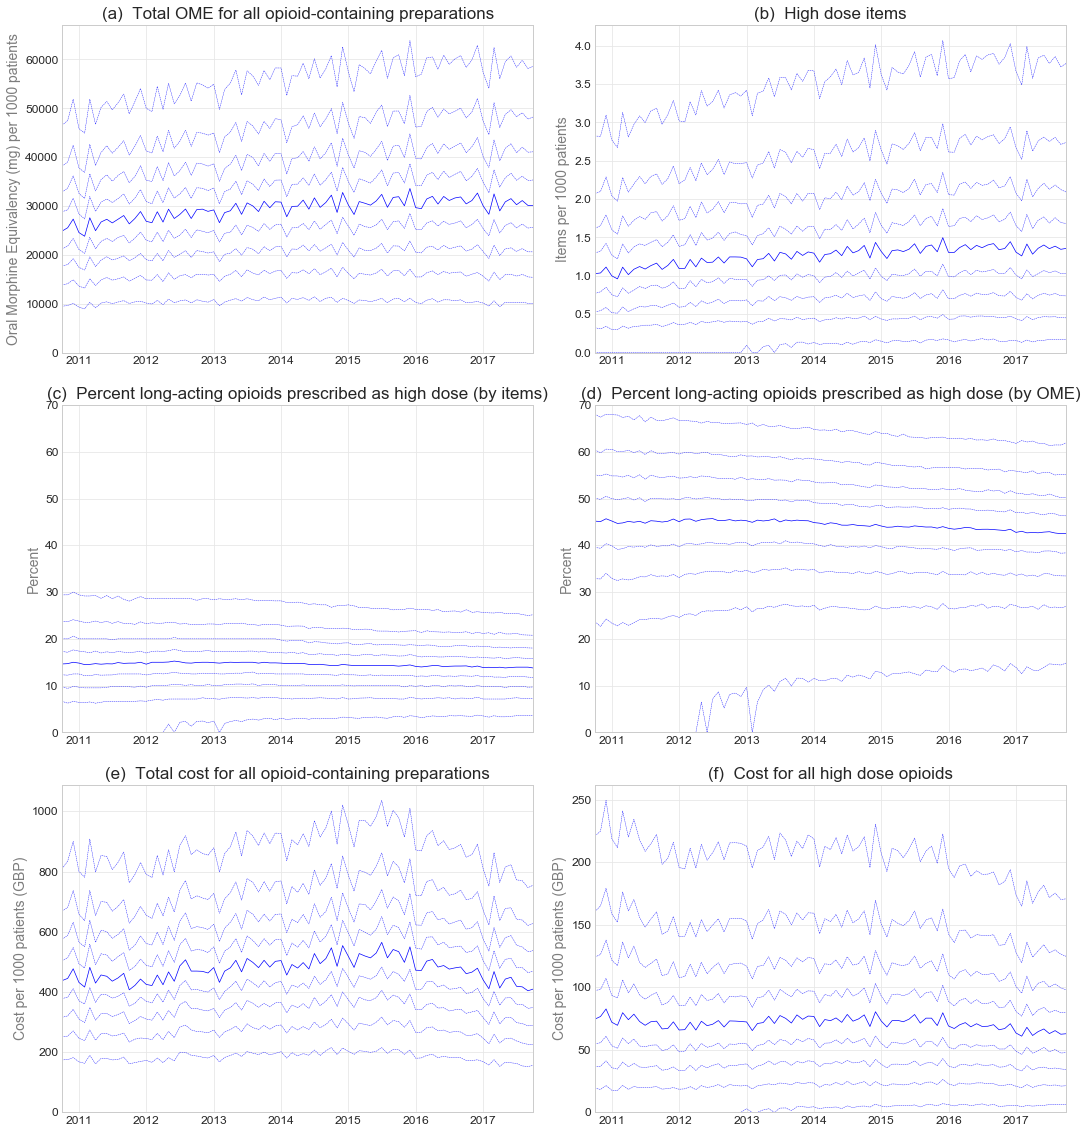

In [6]:

import matplotlib.pyplot as plt
import datetime
import matplotlib.gridspec as gridspec
import seaborn as sns

sns.set_style("whitegrid",{'grid.color': '.9'})
dfp = pc.sort_values(by=["month","measure"])
dfp['month'] = dfp['month'].astype(str)
# set format for dates:
dfp['dates'] = [datetime.datetime.strptime(date, '%Y-%m-%d').date() for date in dfp['month']]


# set sort order of measures manually, and add grid refs to position each subplot:
s = [(0,'Total OME (per 1000)',0,0,"Oral Morphine Equivalency (mg) per 1000 patients", "(a)  Total OME for all opioid-containing preparations"), 
     (1,'High dose items (per 1000)',0,1,"Items per 1000 patients", "(b)  High dose items"), 
     (2,'Percent high dose (by items)',1,0,"Percent",'(c)  Percent long-acting opioids prescribed as high dose (by items)'), 
     (3,'Percent high dose (by OME)',1,1,"Percent",'(d)  Percent long-acting opioids prescribed as high dose (by OME)'), 
     (4,'Total cost (per 1000)',2,0,"Cost per 1000 patients (GBP)", "(e)  Total cost for all opioid-containing preparations"), 
     (5,'Cost high dose opioids (per 1000)',2,1,"Cost per 1000 patients (GBP)", "(f)  Cost for all high dose opioids")
    ]


fig = plt.figure(figsize=(18,20)) 
gs = gridspec.GridSpec(3,2)  # grid layout for subplots

# Plot each subplot using a loop
for i in s:
    ax = plt.subplot(gs[i[2], i[3]])  # position of subplot in grid using coordinates listed in s
    for decile in range(1,10):   # plot each decile line
        data = dfp.loc[(dfp['measure']==i[1]) & (dfp['index']==decile)]
        if decile == 5:
            ax.plot(data["dates"],data['value'],'b-',linewidth=0.7)
        else:
            ax.plot(data["dates"],data['value'],'b--',linewidth=0.4)
    ax.set_ylabel(i[4], size =14, alpha=0.6)
    ax.set_title(i[5],size = 17)
    ax.set_ylim([0,1.05*data["value"].max()])
    if  i[4]=="Percent":    # set y axis limit only for percentage measure
        ax.set_ylim([0, 70])
    ax.tick_params(labelsize=12)
    ax.set_xlim([dfp['dates'].min(), dfp['dates'].max()]) # set x axis range as full date range

plt.subplots_adjust(wspace = 0.13,hspace = 0.16)
plt.show()



## Variation by CCG (maps)

### (a) Aggregate data, create calculated fields

In [7]:
# filter to latest 3 months only
df4 = dftest
df4 = df4.drop(["Is_High_LA","quantity","net_cost"],axis=1)

# group to ccg level and combine the 3 months
df4 = pd.DataFrame(df4.groupby(["pct","chem_substance","Is_LA","High_LA"])["items","total_ome","actual_cost"].sum()).reset_index()

df4["fent_ome"] = np.where((df4["chem_substance"] == "Fentanyl")& (df4["High_LA"]==True),df4["total_ome"],0)
df4["morph_ome"] = np.where((df4["chem_substance"] == "Morphine Sulfate")& (df4["High_LA"]==True),df4["total_ome"],0)
df4["oxyco_ome"] = np.where((df4["chem_substance"] == "Oxycodone Hydrochloride")& (df4["High_LA"]==True),df4["total_ome"],0)
df4["practice_count"] = 1

# aggregate chem substances
df = pd.DataFrame(df4.groupby(["pct","Is_LA","High_LA"]).sum()).reset_index()

# create columns for high dose and long acting OME
df.loc[df["Is_LA"]==True,"Items Long Acting"] = df["items"]
df.loc[df["High_LA"]==True,"Items High Dose"] = df["items"]
df.loc[df["Is_LA"]==True,"OME Long Acting"] = df["total_ome"]
df.loc[df["High_LA"]==True,"OME High Dose"] = df["total_ome"]
df.loc[df["Is_LA"]==True,"Cost Long Acting"] = df["actual_cost"]
df.loc[df["High_LA"]==True,"Cost High Dose"] = df["actual_cost"]

df = df.fillna(0).drop(["Is_LA","High_LA"],axis=1)
df = df.groupby(["pct"]).sum().reset_index()

df3 = df.rename(columns={"total_ome":"Total OME",
                          "items":"Total Items",
                          "actual_cost":"Total Cost"})

#aggregate list sizes up to CCG level and take latest available list sizes only
popccg = pop.loc[pop["month"]==pop["month"].max()]
popccg = popccg.groupby("CCG").sum().reset_index()
df3 = df3.merge(popccg[["CCG","total_list_size"]], right_on="CCG", left_on="pct").drop("CCG",axis=1)

df3["Percent high dose (by items)"] = 100*df3["Items High Dose"]/df3["Items Long Acting"]
df3["Percent high dose (by OME)"] = 100*df3["OME High Dose"]/df3["OME Long Acting"]
df3["Total OME (per 1000)"] = 1000*df3["Total OME"]/df3.total_list_size
df3["Total items (per 1000)"] = 1000*df3["Total Items"]/df3.total_list_size
df3["High dose items (per 1000)"] = 1000*df3["Items High Dose"]/df3.total_list_size
df3["Long acting items (per 1000)"] = 1000*df3["Items Long Acting"]/df3.total_list_size
df3["High dose OME (per 1000)"] = 1000*df3["OME High Dose"]/df3.total_list_size
df3["Long acting OME (per 1000)"] = 1000*df3["OME Long Acting"]/df3.total_list_size
df3["Total cost (per 1000)"] = 1000*df3["Total Cost"]/df3.total_list_size
df3["Cost high dose opioids (per 1000)"] = 1000*df3["Cost High Dose"]/df3.total_list_size
df3.head()

df4 = df3.copy()

df4["% Fentanyl of high dose OME"] = 100*df4["fent_ome"]/df4["OME High Dose"]
df4["% Morphine of high dose OME"] = 100*df4["morph_ome"]/df4["OME High Dose"]
df4["% Oxycodone of high dose OME"] = 100*df4["oxyco_ome"]/df4["OME High Dose"]

df4.head()


,pct,Total Items,Total OME,Total Cost,fent_ome,morph_ome,oxyco_ome,practice_count,Items Long Acting,Items High Dose,...,Total items (per 1000),High dose items (per 1000),Long acting items (per 1000),High dose OME (per 1000),Long acting OME (per 1000),Total cost (per 1000),Cost high dose opioids (per 1000),% Fentanyl of high dose OME,% Morphine of high dose OME,% Oxycodone of high dose OME
0,00C,25784.0,15143713.30,188345.38810,1465380.0,919680.0,1344120.0,29,6205.0,1267.0,...,238.222386,11.706010,57.328960,41315.618792,78874.659768,1740.152336,462.969570,32.769384,20.566233,30.057722
1,00D,99149.0,53178686.50,630149.95246,3785580.0,3784560.0,3571300.0,33,19584.0,3446.0,...,339.656058,11.805008,67.089171,41454.749752,87821.268199,2158.713139,388.135275,31.283055,31.274626,29.512300
2,00J,71455.0,36092463.80,437828.84919,1906740.0,2405080.0,1796000.0,32,12842.0,2094.0,...,275.285379,8.067281,49.474702,26572.206791,62691.216526,1686.766227,261.041306,27.644859,34.870038,26.039296
3,00K,80822.0,52558383.37,588703.47529,4068540.0,5768280.0,3344880.0,31,15929.0,3298.0,...,272.108706,11.103592,53.629205,47150.107231,89194.268419,1982.026440,456.953020,29.051513,41.188549,23.884200
4,00L,87209.0,48467320.40,528864.25202,2094660.0,5737890.0,3779480.0,31,17101.0,3409.0,...,268.213244,10.484456,52.594511,37328.742603,74685.679752,1626.533923,343.927811,17.257945,47.274590,31.139211


### (b) Summary table

In [8]:
table = df4[['Total items (per 1000)','Total OME (per 1000)','High dose items (per 1000)',
     'Percent high dose (by items)', 'Percent high dose (by OME)','Total cost (per 1000)',
         '% Fentanyl of high dose OME','% Morphine of high dose OME',
          '% Oxycodone of high dose OME']].agg([min, "median", max]).transpose()
table["fold-difference"] = table["max"]/table["min"]
table

,min,median,max,fold-difference
Total items (per 1000),61.854627,175.695429,355.752795,5.751434
Total OME (per 1000),27129.395618,104509.011022,215087.701162,7.928216
High dose items (per 1000),0.957289,5.234605,14.410714,15.053670
Percent high dose (by items),6.691012,15.375494,22.835456,3.412855
Percent high dose (by OME),25.982464,45.854955,58.228033,2.241051
Total cost (per 1000),482.859640,1382.070344,2745.836119,5.686613
% Fentanyl of high dose OME,17.257945,38.306674,60.536829,3.507766
% Morphine of high dose OME,5.245501,24.159412,56.340817,10.740788
% Oxycodone of high dose OME,9.052360,26.229936,47.113635,5.204569


### (c) Join to geographical data

In [9]:

spending = df4.copy()
names = pd.read_csv('ccg_for_map.csv')
spending2 = spending.merge(names[['CCG17CDH','CCG17NM']],left_on="pct",right_on="CCG17CDH")
spending2['name'] = spending2['CCG17NM'].str.upper()
spending2['name'] = spending2["name"].str.replace("&","AND")
spending2 = spending2.drop(["CCG17NM","CCG17CDH","fent_ome","morph_ome","oxyco_ome"],axis=1).set_index('name')
spending2 = spending2.round(0)

spending2 # 207 rows

,pct,Total Items,Total OME,Total Cost,practice_count,Items Long Acting,Items High Dose,OME Long Acting,OME High Dose,Cost Long Acting,...,Total items (per 1000),High dose items (per 1000),Long acting items (per 1000),High dose OME (per 1000),Long acting OME (per 1000),Total cost (per 1000),Cost high dose opioids (per 1000),% Fentanyl of high dose OME,% Morphine of high dose OME,% Oxycodone of high dose OME
name,,,,,,,,,,,,,,,,,,,,,
NHS DARLINGTON CCG,00C,25784.0,15143713.0,188345.0,29,6205.0,1267.0,8536999.0,4471796.0,106747.0,...,238.0,12.0,57.0,41316.0,78875.0,1740.0,463.0,33.0,21.0,30.0
"NHS DURHAM DALES, EASINGTON AND SEDGEFIELD CCG",00D,99149.0,53178686.0,630150.0,33,19584.0,3446.0,25635906.0,12101056.0,280633.0,...,340.0,12.0,67.0,41455.0,87821.0,2159.0,388.0,31.0,31.0,30.0
NHS NORTH DURHAM CCG,00J,71455.0,36092464.0,437829.0,32,12842.0,2094.0,16272571.0,6897268.0,189937.0,...,275.0,8.0,49.0,26572.0,62691.0,1687.0,261.0,28.0,35.0,26.0
NHS HARTLEPOOL AND STOCKTON-ON-TEES CCG,00K,80822.0,52558383.0,588703.0,31,15929.0,3298.0,26492571.0,14004572.0,286779.0,...,272.0,11.0,54.0,47150.0,89194.0,1982.0,457.0,29.0,41.0,24.0
NHS NORTHUMBERLAND CCG,00L,87209.0,48467320.0,528864.0,31,17101.0,3409.0,24283899.0,12137366.0,228779.0,...,268.0,10.0,53.0,37329.0,74686.0,1627.0,344.0,17.0,47.0,31.0
NHS SOUTH TEES CCG,00M,90537.0,54197446.0,655059.0,33,17011.0,3338.0,25865042.0,13004576.0,309011.0,...,306.0,11.0,57.0,43927.0,87366.0,2213.0,473.0,27.0,40.0,27.0
NHS SOUTH TYNESIDE CCG,00N,43401.0,23523511.0,264723.0,32,7288.0,1480.0,11416137.0,5723296.0,124627.0,...,276.0,9.0,46.0,36447.0,72700.0,1686.0,376.0,24.0,34.0,36.0
NHS SUNDERLAND CCG,00P,89051.0,43007166.0,526647.0,31,15834.0,2390.0,19591959.0,8527612.0,236496.0,...,314.0,8.0,56.0,30033.0,68999.0,1855.0,313.0,26.0,34.0,32.0
NHS BLACKBURN WITH DARWEN CCG,00Q,41787.0,24632853.0,304450.0,25,9240.0,1689.0,13279606.0,6326066.0,169605.0,...,239.0,10.0,53.0,36181.0,75952.0,1741.0,397.0,35.0,26.0,34.0


### (d) Plot maps

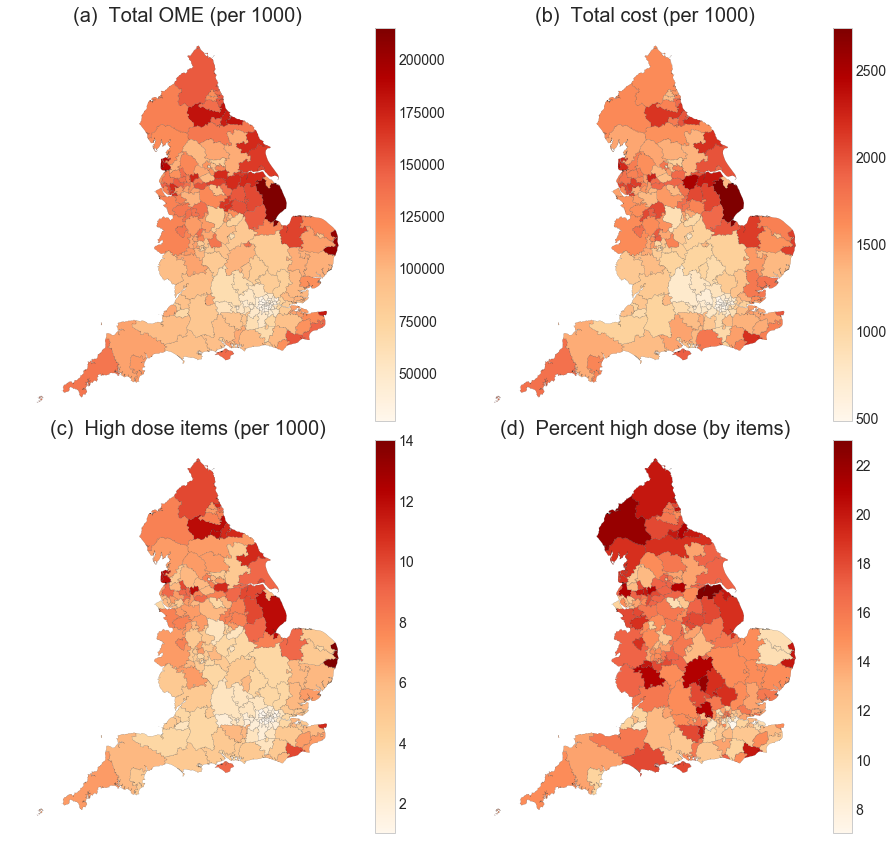

In [68]:
import matplotlib.gridspec as gridspec
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
#from matplotlib import verbose
#verbose.level = 'helpful'    

# from our API https://openprescribing.net/api/1.0/org_location/?org_type=ccg
ccgs = gpd.read_file('ccgs.json').set_index('name')

ccgs = ccgs[~ccgs['geometry'].isnull()]  # remove ones without geometry - these are federations rather than individual CCGs
gdf = ccgs.join(spending2)

# set sort order of measures manually, and add grid refs to position each subplot:
s = [(0,'Total OME (per 1000)',0,0,'(a)  '),      (1,'Total cost (per 1000)',0,1,'(b)  '), 
     (2,'High dose items (per 1000)',1,0,'(c)  '),      (3,'Percent high dose (by items)',1,1,'(d)  ')
    ]

fig = plt.figure(figsize=(16,30))
gs = gridspec.GridSpec(4,2)  # grid layout for subplots

for i in s:
    ax = plt.subplot(gs[i[2], i[3]])  # position of subplot in grid using coordinates listed in s
    gdf.plot(ax=ax,column=i[1],  edgecolor='black', linewidth=0.1, legend=True, cmap='OrRd')
    ax.set_aspect(1.63)
    ax.set_title(i[4]+i[1],size = 20)
    cb_ax = fig.axes[2*(i[0])+1] # extract legend labels from list of axis/legend labels
    cb_ax.tick_params(labelsize=14)
    plt.axis('off')

plt.subplots_adjust(wspace = 0.05,hspace = 0.05)
plt.show()



### (e) Plot additional maps for some percentage measures

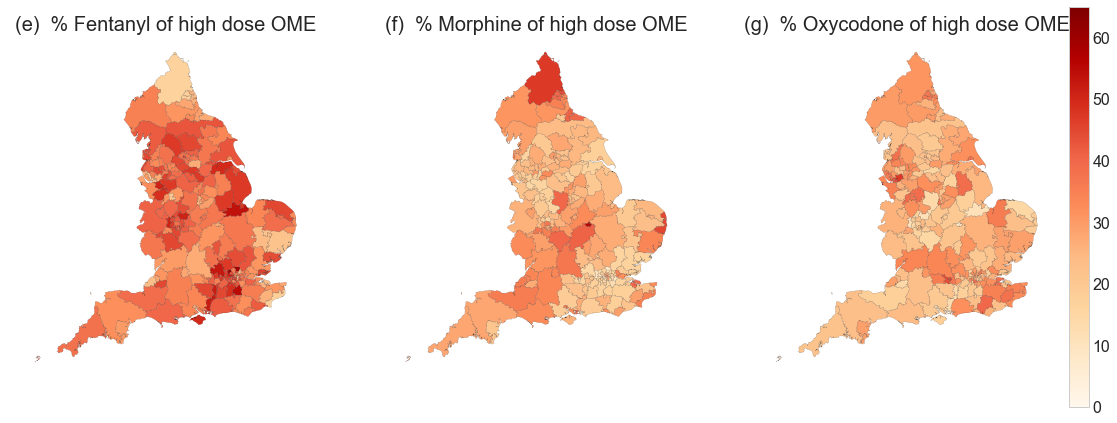

In [87]:
import matplotlib.gridspec as gridspec
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd

# set sort order of measures manually, and add grid refs to position each subplot:
s = [(0,'% Fentanyl of high dose OME',0,0,'(e)  ',False),      (1,'% Morphine of high dose OME',0,1,'(f)  ',False), 
     (2,'% Oxycodone of high dose OME',0,2,'(g)  ',True)
    ]

fig = plt.figure(figsize=(17,6))
#plt.subplots(ncols=3)
gs = gridspec.GridSpec(1,3, width_ratios=[4,4,5])  # grid layout for subplots; 
# adjust ratios to allow all plots to appear same size despite the third having a legend.

# set common value limits for colour scale
vmin, vmax = 0, 65

for i in s:
    ax = plt.subplot(gs[0,i[0]])  # position of subplot in grid using coordinates listed in s
    gdf.plot(ax=ax,column=i[1],  edgecolor='black', linewidth=0.1, cmap='OrRd', legend = i[5], vmin=vmin, vmax=vmax)   
    ax.set_title(i[4]+i[1],size = 20)
    ax.set_aspect(1.63)  # aspect for correct lat/long
    plt.axis('off')
cb_ax = fig.axes[3] # take legend label (4th item in list of axis/legend labels for all plots)
cb_ax.tick_params(labelsize=16) # set label size for legend

plt.tight_layout()
plt.show()

## Potential cost savings

In [62]:
# Extract lowest practice percentile for both high-dose items and cost per 1000 population for latest 3 months
lowest_dec = pc[["month","measure","value"]].loc[(pc["month"]>pc["month"].max() - pd.DateOffset(months=3)) 
       & (pc["percentile"] == 0.1)].fillna(0)
lowest_dec.loc[lowest_dec["measure"]=="High dose items (per 1000)","measure"] = "high dose items"
lowest_dec.loc[lowest_dec["measure"]=="Cost high dose opioids (per 1000)","measure"] = "high dose cost"

# extract data on high dose items for latest 3 months
dfs = pd.DataFrame(df2[["practice","month","total_list_size","Items High Dose","Total Cost","Cost High Dose"]].set_index(["practice","month","total_list_size"]).stack()).reset_index().rename(columns={"level_3":"measure",0:"actual_value"})
dfs.loc[dfs["measure"]=="Items High Dose","measure"] = "high dose items"
dfs.loc[dfs["measure"]=="Cost High Dose","measure"] = "high dose cost"
savings = dfs.merge(lowest_dec,on=["month","measure"])

savings["target_value"] = savings["total_list_size"]*savings["value"]/1000
savings["potential_saving"] = savings["actual_value"] - savings["target_value"]
savings = savings.fillna(0)
savings.loc[savings["potential_saving"]<0,"potential_saving"] = 0

print("Practices at the lowest decile over the latest 3 months prescribed: ", lowest_dec.loc[lowest_dec["measure"]=="high dose items"].mean().round(2).value, 
      "items / £", lowest_dec.loc[lowest_dec["measure"]=="high dose cost"].mean().round(2).value, " per 1,000 patients")

print(savings.groupby("measure")["actual_value","potential_saving"].sum())


Practices at the lowest decile over the latest 3 months prescribed:  0.17 items / £ 6.16  per 1,000 patients
                 actual_value  potential_saving
measure                                        
Total Cost       7.766378e+07      3.836325e+06
high dose cost   1.421974e+07      1.318834e+07
high dose items  3.102580e+05      2.815176e+05
